In [1]:
%matplotlib inline
from __future__ import print_function
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [2]:
# set up file names and pathes
dataDir='.'
dataType='val2014'
algName = 'fakecap'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]

# download Stanford models
!./get_stanford_models.sh

Found Stanford CoreNLP.


In [3]:
# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
0:00:00.585984
creating index...
index created!
Loading and preparing results...     
DONE (t=0.02s)
creating index...
index created!


In [4]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'reflen': 9855, 'guess': [9893, 8893, 7893, 6893], 'testlen': 9893, 'correct': [5732, 2510, 1043, 423]}
('ratio:', 1.003855910705124)
Bleu_1: 0.579
Bleu_2: 0.404
Bleu_3: 0.279
Bleu_4: 0.191
computing METEOR score...
METEOR: 0.195
computing Rouge score...
ROUGE_L: 0.396
computing CIDEr score...
CIDEr: 0.600
computing SPICE score...
SPICE: 0.133


In [5]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

CIDEr: 0.600
Bleu_4: 0.191
Bleu_3: 0.279
Bleu_2: 0.404
Bleu_1: 0.579
ROUGE_L: 0.396
METEOR: 0.195
SPICE: 0.133


ground truth captions
A train traveling down tracks next to lights.
A blue and silver train next to train station and trees.
A blue train is next to a sidewalk on the rails.
A passenger train pulls into a train station.
A train coming down the tracks arriving at a station.


generated caption (CIDEr score 1.0)
train traveling down a track in front of a road


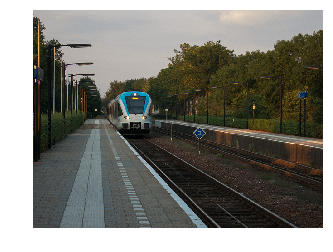

In [6]:
# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']<30]
print('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print('generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

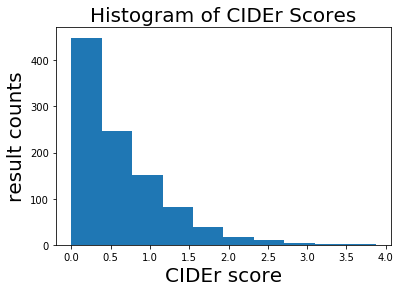

In [7]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [8]:
# save evaluation results to ./results folder
json.dump(cocoEval.evalImgs, open(evalImgsFile, 'w'))
json.dump(cocoEval.eval,     open(evalFile, 'w'))